# Analysis of Three-phase Signals using Singular Value Decomposition


In [173]:
import numpy as np
import numpy.linalg as lg
import scipy.signal as sig
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

<div class="alert alert-info"> You can use this code without restriction but please don't forget to add an appropriate reference to the paper "Monitoring of Three-Phase Signal based on Singular-Value Decomposition" <a href=https://ieeexplore.ieee.org/document/8636981">[CHO19]</a></div>

This notebook presents some results of the paper entitled ["Monitoring of Three-Phase Signal based on Singular-Value Decomposition"](https://www.researchgate.net/publication/330941548_Monitoring_of_Three-Phase_Signals_based_on_Singular-Value_Decomposition). In particular, it shows that the SVD decomposition can be a natural alternative to the commonly used Clarke transform for the analysis of unbalanced three-phase signals. 




## Three-phase Signal Model

In power systems, it is usualy more convenient to transmit three-phase signals. Under nominal condition the three-phase signal has a particular structure. Indeed, each phase is simply composed of a $60$ Hz (or $50$ Hz) sine wave. Furthermore, the three phases are simply phase-shifted from each other by $2\pi/3$. In practice, many deviations can occur and the three-phase signal can be described by the following more general model ($k=0,1,2$):

$$x_k[n]=a_k \cos(2\pi n f_0/F_s +\phi_k)+b_k[n]$$

where $c_k=a_k e^{j\phi_k}$ correspond to the complex phasor on phase $k$, $f_0$ is the signal frequency and $F_s$ is the sampling rate. An additive signal $b_k[n]$ is usually introduced to model the presence of noise.




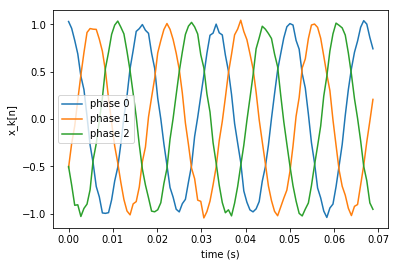

In [174]:
def create_signal(c_vect,f0=60,N=1000,Fs=24*60,sigma2=0.001):
    # Create three phase signal
    X = np.zeros((3,N))
    b_rv = norm(loc=0,scale=np.sqrt(sigma2))  # gaussian noise
    t_vect = np.arange(N)/Fs
    for k in range(3):
        a_k = np.abs(c_vect[k])
        phi_k = np.angle(c_vect[k])
        X[k,:] = a_k*np.cos(2*np.pi*f0*t_vect+phi_k) + b_rv.rvs(size=(1,N))

    return t_vect, X

def plot_signal(t,signal):
    # Component shown in R^3
    for k in range(3):
        plt.plot(t,signal[k,:],label="phase {}".format(k))
    plt.xlabel("time (s)")
    plt.ylabel("x_k[n]")
    plt.legend()
    
N = 100
sigma2 = 0.001
k_vect = np.arange(3)
c_bal = np.exp(-2j*np.pi*k_vect/3)
t, X = create_signal(c_bal,60,N=N,sigma2=sigma2)
plot_signal(t,X)

Instead of plotting the three signals versus time, it is also interesting to visualize the multidimensional signal in a 3D space. This representation leads to a better interpretation of the underlying signal subspace. 

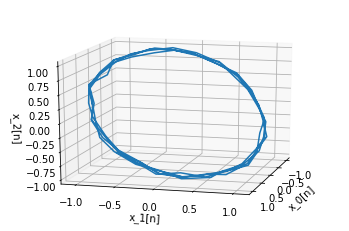

In [175]:
def plot_3D_signal(signal):  
    fig=plt.figure()
    ax = fig.gca(projection='3d')
    ax.view_init(15, 15)
    ax.plot(signal[0,:],signal[1,:],signal[2,:])
    ax.set_xlabel("x_0[n]")
    ax.set_ylabel("x_1[n]")
    ax.set_zlabel("x_2[n]")
    
plot_3D_signal(X)

## Case of Balanced Three-phase signals: The Clarke Transform

Under balanced conditions, the complex phasors are given by $c_k=c_0 e^{2j\pi k/3}$. In this context, it is known that the signal subspace is a circle whose normal vector given by $\frac{1}{\sqrt{3}}[1,1,1]$ [CHO19](https://ieeexplore.ieee.org/document/8636981). This is illustrated in the following figure.

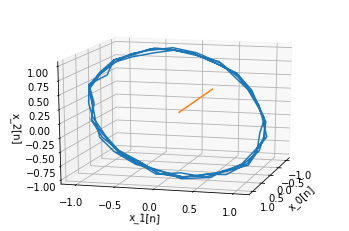

In [176]:
plot_3D_signal(X)
plt.plot([0,1/np.sqrt(3)],[0,1/np.sqrt(3)],[0,1/np.sqrt(3)]);

From a statistical viewpoint, it is usually interesting to reduce the dimension of multi-dimensional signal. in power electronic, a commonly used approach for dimensional reduction is the Clarke transform. The Clarke transform is a simple linear transform which can be expressed under a matrix form as

$$\begin{bmatrix}y_0[n]\\y_1[n]\end{bmatrix}=\sqrt{\frac{2}{3}}\begin{bmatrix}1 &-\frac{1}{2} & -\frac{1}{2}\\ 0 & \frac{\sqrt{3}}{2}&-\frac{\sqrt{3}}{2}\end{bmatrix}\begin{bmatrix}x_0[n]\\x_1[n]\\ x_2[n]\end{bmatrix}$$

This transform has many interesting properties. Indeed, for perfectly balanced system i.e. when $c_k=c_0 e^{2j\pi k}{3}$ and under noiseless condition, it has been demonstrated that the Clarke transform can directly extract the signal subspace. In other terms, the Clarke transform simply projects the 3 phase signal into a plane whose normal vector is given by $\frac{1}{\sqrt{3}}[1,1,1]$. In pratice, instead of working in $\mathbb{R}^2$, it is more elegant to work in $\mathbb{C}$. Therefore, many authors prefer to analyse the 1D complex signal $z[n]$ defined as

$$z[n]=y_0[n]+jy_1[n]$$

This component is sometimes called the instantaneous positive sequence components. To illustrate this technique, the next figure shows the two Clarke components $y_0[n]$ and $y_1[n]$ and the complex signal $z[n]$. As we can observe, the signal $z[n]$ describes a circle in the complex plane with a constant rotating speed equals to $f_0$. To estimate the signal frequency, it is therefore natural to keep the location of the peek of the periodogram of $z[n]$ i.e.

$$\widehat{f}_0=\arg \max_{f} \mathcal{P}_z(f)$$

where $\mathcal{P}_z(f)$ is the periodogram of $z[n]$. In fact, it has been shown in [[CHO15]](https://ieeexplore.ieee.org/document/7281667) that this natural frequency estimator corresponds to the exact Maximum Likelihood frequency estimator under Gaussian noise.

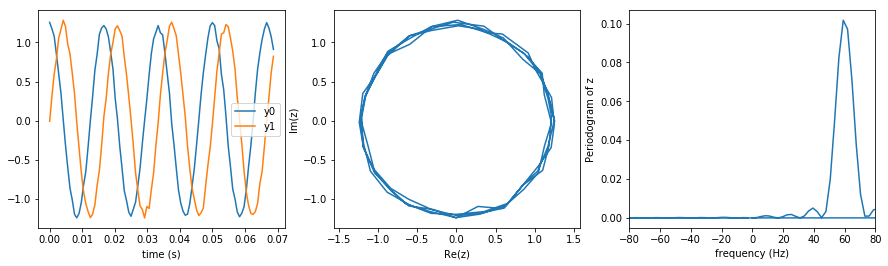

In [177]:
def plot_2D_signals(t,Y,Fs=24*60):
    
    # Component shown in R^2
    plt.figure(figsize=(15, 4))
    plt.subplot(131)
    plt.plot(t,Y[0,:],label="y0")
    plt.plot(t,Y[1,:],label="y1")
    plt.xlabel("time (s)")
    plt.legend()
    
    # Component shown in C
    z=Y[0,:]+1j*Y[1,:]
    plt.subplot(132)
    plt.plot(np.real(z),np.imag(z))
    plt.xlabel("Re(z)")
    plt.ylabel("Im(z)")
    plt.axis("equal")
    
    # Periodogram
    f, Pxx_den = sig.periodogram(z,fs=Fs,nfft=512,return_onesided=False)
    plt.subplot(133)
    plt.plot(f, Pxx_den)
    plt.xlim([-80,80])
    plt.xlabel("frequency (Hz)")
    plt.ylabel("Periodogram of z")

# Clarke transform
M = np.sqrt(2/3)*np.array([[1,-1/2,-1/2],[0,np.sqrt(3)/2,-np.sqrt(3)/2]])
Y=np.matmul(M,X)
plot_2D_signals(t,Y)

So what's wring with the Clarke Transform ? In fact, the main problem of the Clarke transform is the balanced assumption. When the three-phase signal is not balanced, the normal vector has a more complicated expression and the Clarke transform is not able to project the 3D signal into the signal subspace. In this context, the signal $z[n]$ no longer describes a circle but follows an ellipsoid in the complex plane. It follows that the periodogram of $z[n]$ contains two components located at $f_0$ and $-f_0$. 

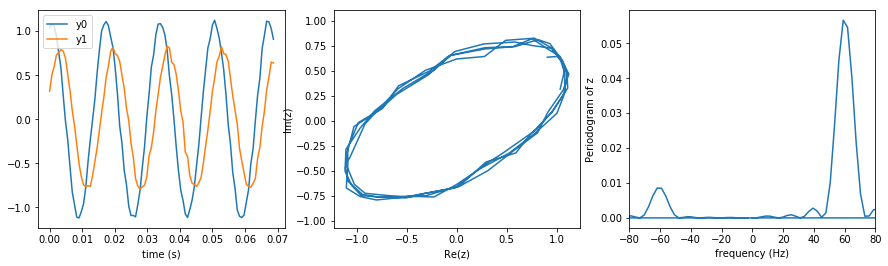

In [178]:
c_unbal= c_bal
c_unbal[1]=c_unbal[1]*0.2
t, X_unbal = create_signal(c_unbal,60,N=100)
Y_unbal=np.matmul(M,X_unbal)
plot_2D_signals(t,Y_unbal)

Unfortunately, this negative frequency usually complicates the estimation of the fundamental frequency $f_0$. As demonstrated in [[CHO19]](https://www.researchgate.net/publication/331959977_Theoretical_performances_of_the_ML_frequency_estimator_for_unbalanced_three-phase_systems), simple frequency estimators based on the periodogram of $z[n]$ such the one proposed by Xia & Al [[XIA18]](https://www.researchgate.net/publication/322583470_Maximum_Likelihood_Parameter_Estimation_of_Unbalanced_Three-Phase_Power_Signals) usually suffers from bad statistical performance which are mainly caused by the estimator bias.

## Case of Unbalanced Three-phase signals: The SVD

In the paper entitled ["Monitoring of Three-Phase Signal based on Singular-Value Decomposition"](https://www.researchgate.net/publication/330941548_Monitoring_of_Three-Phase_Signals_based_on_Singular-Value_Decomposition), we have proposed a simple technique for the analysis of three-phase unbalanced signals. This technique is based on a matrix decomposition tool called the Singular-Value Decomposition (SVD). The SVD can decomposed any $M\times M$ matrix $\mathbf{X}$ as the product of three matrices as:

$$\mathbf{X}=\mathbf{U}\mathbf{S}\mathbf{V}^T$$

where

* $\mathbf{U}=[\mathbf{u}_{M-1},\cdots,\mathbf{u}_0]$ is an $M\times M$ orthogonal matrix. This matrix contains the left singular vectors of $\mathbf{X}$.
* $\mathbf{S}=\text{diag}(\lambda_M,\cdots,\lambda_0)$ is a diagonal $M\times M$ matrix with non-negative numbers on the diagonal. The diagonal elements are assumed to be sorted in decreasing order and are called the singular-values of $\mathbf{X}$.
* $\mathbf{V}=[\mathbf{v}_{M-1},\cdots,\mathbf{v}_0]$ is an $M\times N$ semi-orthogonal matrix. This matrix contains the right singular vectors of $\mathbf{X}$.

By using the SVD on the three-phase signal, we can extract many information about the signal subspace. 


### Estimation of the Normal Vector 

As illustrated in the following figure, the normal vector simply corresponds to $\mathbf{u}_0$ whatever the balanced assumption. This property can be further exploited to detect unbalanced signals.

u_0=[0.18275695 0.96535303 0.1862617 ]^T


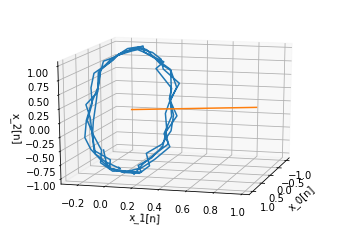

In [179]:
U,S,VT=lg.svd(X_unbal)
u0=U[:,-1]
print("u_0={}^T".format(u0))

plot_3D_signal(X_unbal)
plt.plot([0,u0[0]],[0,u0[1]],[0,u0[2]]);

### Estimation of the Noise variance

The noise variance can be estimated by the smallest singular values of $\mathbf{X}$ as:

$$\widehat{\sigma}^2=\frac{\lambda_0^2}{N}$$

In [180]:
sigma2_est = (1/N)*(S[-1]**2)

print("sigma2: true value={}".format(sigma2))
print("sigma2: estimated value={}".format(sigma2_est))

sigma2: true value=0.001
sigma2: estimated value=0.0009742509113381802


### Estimation of the signal frequency

The right singular vectors contains the information about the signal frequency. Indeed, by constructing a complex signal from the two "largest" right singular vectors, we obtain a powerful alternative to the complex signal $z[n]$. In particular, we have shown in [[CHO19]](https://www.researchgate.net/publication/330941548_Monitoring_of_Three-Phase_Signals_based_on_Singular-Value_Decomposition) that the frequency estimator obtained by maximising the periodogram of the SVD $z[n]$ leads to near optimal statistical performance and has a moderate computational complexity 


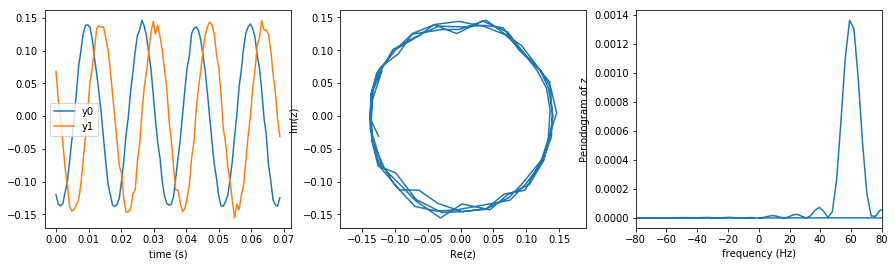

In [181]:
V_unbal=VT[0:2,:]
plot_2D_signals(t,V_unbal)